# Latest Version
Using modified Deepseek code and dummy data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VARMAX

In [2]:
# Load the data (replace with your file paths)
esg_data = pd.read_csv("dummy_esg_ratings_10years.csv")
financial_data = pd.read_csv("dummy_financial_data_10years.csv")

# Merge the datasets on Company ID and Year
merged_data = pd.merge(esg_data, financial_data, on=["Company_Name", "Company_ID", "Year"], how="inner")

# Pivot the data to have years as rows and variables as columns
# We'll focus on one company for simplicity (e.g., GreenTech Solutions)
company_data = merged_data[merged_data["Company_Name"] == "GreenTech Solutions"]
company_data = company_data[["Year", "ESG_Rating", "Stock_Price", "ROA", "ROE"]]

# Set the year as the index
company_data.set_index("Year", inplace=True)

# Ensure the index is in a supported format
# Convert the 'Year' column to a DatetimeIndex with yearly frequency
company_data.index = pd.to_datetime(company_data.index, format='%Y')

# Check for missing values
print(company_data.isnull().sum())

ESG_Rating     0
Stock_Price    0
ROA            0
ROE            0
dtype: int64


In [3]:
company_data

,ESG_Rating,Stock_Price,ROA,ROE
Year,,,,
2014-01-01,7.2,45.3,0.08,0.15
2015-01-01,7.5,48.5,0.09,0.16
2016-01-01,7.8,52.1,0.10,0.18
2017-01-01,8.1,56.4,0.11,0.20
2018-01-01,8.4,60.2,0.12,0.22
2019-01-01,8.7,65.0,0.13,0.24
2020-01-01,8.9,70.5,0.14,0.26
2021-01-01,9.0,75.8,0.15,0.28
2022-01-01,9.1,80.2,0.16,0.30


In [4]:
# Prepare endogenous and exogenous variables
endog = company_data[['ROA', 'ROE', 'Stock_Price']]
exog = company_data[['ESG_Rating']]

# Fit the VARMAX model
model = VARMAX(endog, exog=exog, order=(1, 0))  # Adjust order as needed
results = model.fit(maxiter=1000, disp=False)

# Summary of the model
print(results.summary())

# Impulse response analysis
irf = results.impulse_responses(steps=10)
print(irf)

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


                                 Statespace Model Results                                
Dep. Variable:     ['ROA', 'ROE', 'Stock_Price']   No. Observations:                   10
Model:                                   VARX(1)   Log Likelihood                  32.584
                                     + intercept   AIC                            -23.168
Date:                           Mon, 10 Mar 2025   BIC                            -16.813
Time:                                   13:22:57   HQIC                           -30.138
Sample:                               01-01-2014                                         
                                    - 01-01-2023                                         
Covariance Type:                             opg                                         
Ljung-Box (L1) (Q):       0.01, 1.23, 0.08   Jarque-Bera (JB):     4.24, 4.28, 2.58
Prob(Q):                  0.92, 0.27, 0.77   Prob(JB):             0.12, 0.12, 0.28
Heteroskedasticity (H)

# First Forecast 
No Comparison to Changing ESG practices    
Uses last value of the ESG (ie 2023 value) and assumes ESG_Rating remains consistent for all projected years

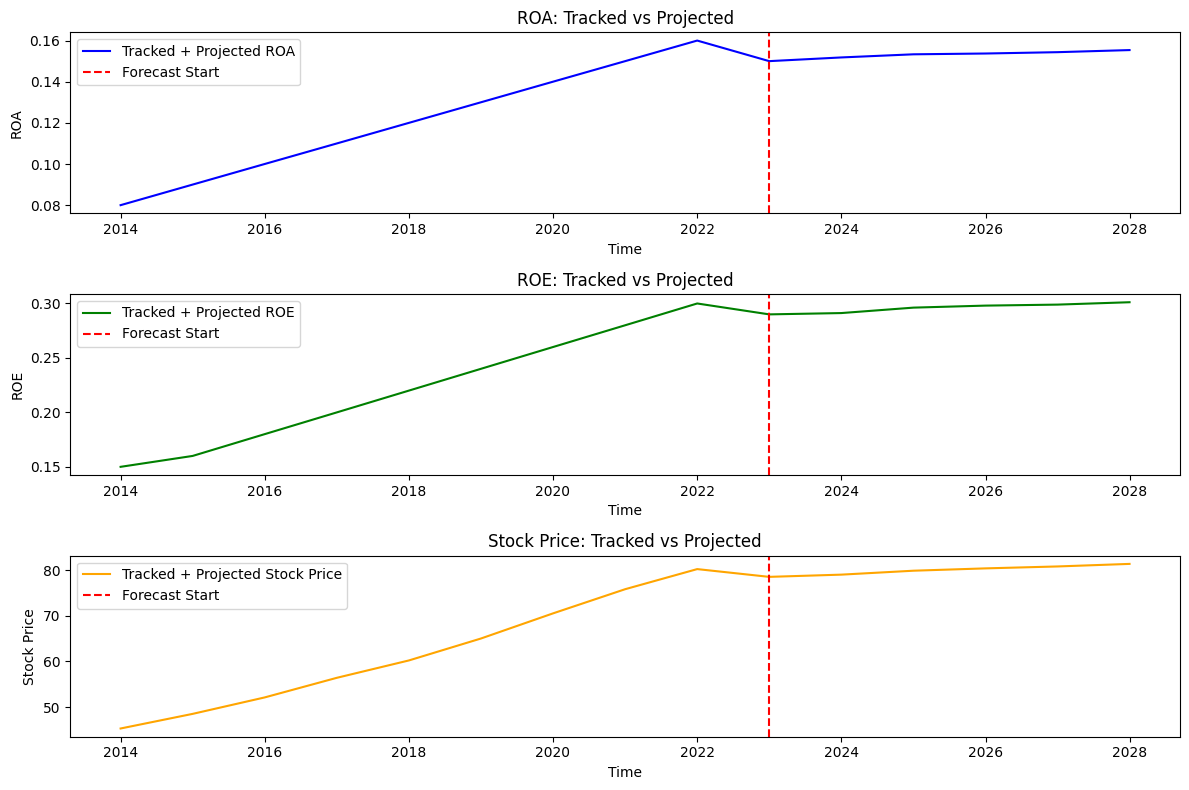

In [5]:
forecast_steps = 5

# Forecast with original ESG scores
latest_esg = exog.iloc[-1].values[0]  # Latest ESG value (e.g., 8.7 for 2023)
consistent_esg = np.full(forecast_steps, latest_esg).reshape(-1, 1)  # Constant ESG array
forecast = results.forecast(steps=forecast_steps, exog=consistent_esg)

# Combine historical and forecasted data
historical = endog
forecasted = forecast
combined = pd.concat([historical, forecasted])

# Plot the results
plt.figure(figsize=(12, 8))

# Plot ROA
plt.subplot(3, 1, 1)
plt.plot(combined.index, combined['ROA'], label='Tracked + Projected ROA', color='blue')
plt.axvline(x=historical.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('ROA: Tracked vs Projected')
plt.xlabel('Time')
plt.ylabel('ROA')
plt.legend()

# Plot ROE
plt.subplot(3, 1, 2)
plt.plot(combined.index, combined['ROE'], label='Tracked + Projected ROE', color='green')
plt.axvline(x=historical.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('ROE: Tracked vs Projected')
plt.xlabel('Time')
plt.ylabel('ROE')
plt.legend()

# Plot Stock Price
plt.subplot(3, 1, 3)
plt.plot(combined.index, combined['Stock_Price'], label='Tracked + Projected Stock Price', color='orange')
plt.axvline(x=historical.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('Stock Price: Tracked vs Projected')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.tight_layout()
plt.show()

# Second Forecast
Compares consistent ESG scores to improving ESG scores    
Uses hardcoded improved scores (improve by 0.1 every year)

In [33]:
forecast_steps = 5

# Forecast with original ESG scores
latest_esg = exog.iloc[-1].values[0]  # Latest ESG value (e.g., 8.7 for 2023)
consistent_esg = np.full(forecast_steps, latest_esg).reshape(-1, 1)  # Constant ESG array
forecast_consistent = results.forecast(steps=forecast_steps, exog=consistent_esg)

# Forecast with improved ESG scores
improved_esg = np.array([8.7, 8.8, 8.9, 9.0, 9.1]).reshape(-1, 1)  # Higher ESG scores
forecast_improved = results.forecast(steps=forecast_steps, exog=improved_esg)

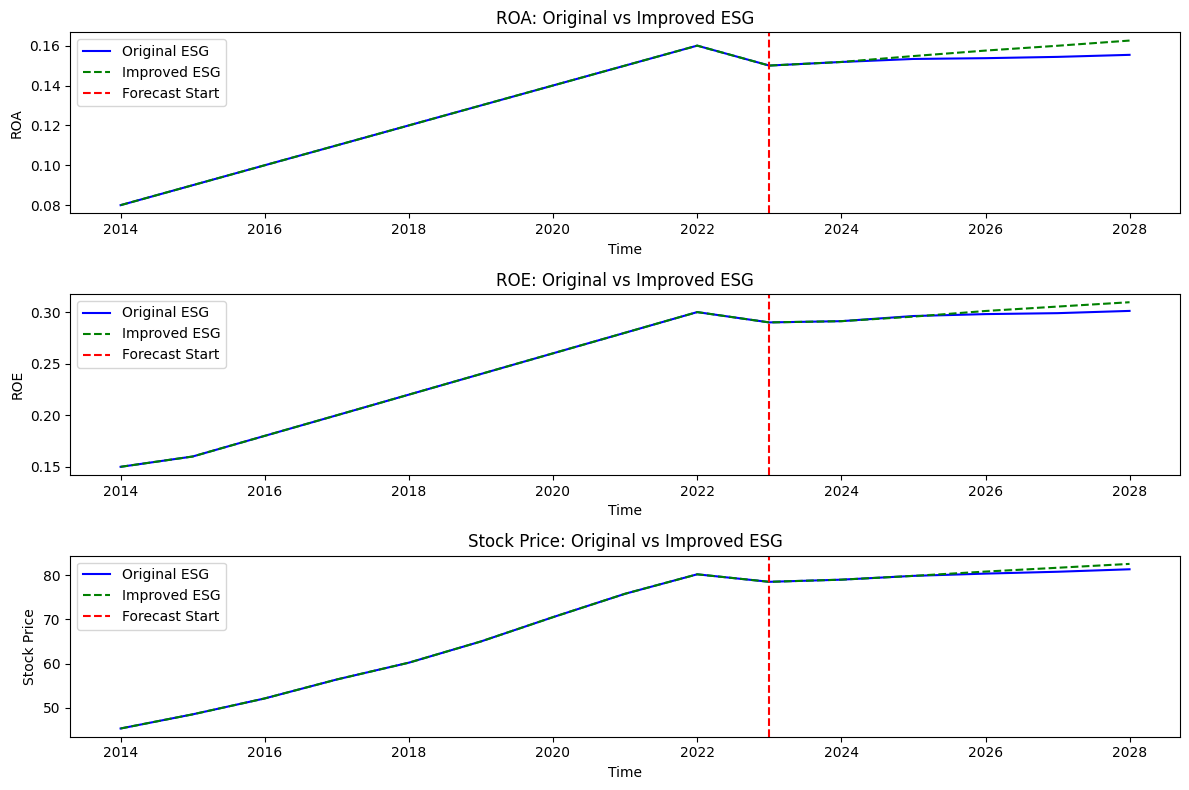

In [34]:
# Combine historical and forecasted data
historical = endog
combined_consistent = pd.concat([historical, forecast_consistent])
combined_improved = pd.concat([historical, forecast_improved])

# Plot the results
plt.figure(figsize=(12, 8))

# Plot ROA
plt.subplot(3, 1, 1)
plt.plot(combined_consistent.index, combined_consistent['ROA'], label='Original ESG', color='blue')
plt.plot(combined_improved.index, combined_improved['ROA'], label='Improved ESG', color='green', linestyle='--')
plt.axvline(x=historical.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('ROA: Original vs Improved ESG')
plt.xlabel('Time')
plt.ylabel('ROA')
plt.legend()

# Plot ROE
plt.subplot(3, 1, 2)
plt.plot(combined_consistent.index, combined_consistent['ROE'], label='Original ESG', color='blue')
plt.plot(combined_improved.index, combined_improved['ROE'], label='Improved ESG', color='green', linestyle='--')
plt.axvline(x=historical.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('ROE: Original vs Improved ESG')
plt.xlabel('Time')
plt.ylabel('ROE')
plt.legend()

# Plot Stock Price
plt.subplot(3, 1, 3)
plt.plot(combined_consistent.index, combined_consistent['Stock_Price'], label='Original ESG', color='blue')
plt.plot(combined_improved.index, combined_improved['Stock_Price'], label='Improved ESG', color='green', linestyle='--')
plt.axvline(x=historical.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('Stock Price: Original vs Improved ESG')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:

# Add a 'Scenario' column to distinguish between constant and improved ESG
forecast_consistent['Scenario'] = 'Consistent ESG'
forecast_improved['Scenario'] = 'Improved ESG'

# Add ESG ratings used for prediction
forecast_consistent['ESG_Rating'] = consistent_esg.flatten()  # ESG ratings for consistent scenario
forecast_consistent = forecast_consistent.reset_index()
forecast_consistent = forecast_consistent.rename(columns={'index': 'Year'})
forecast_improved['ESG_Rating'] = improved_esg.flatten()  # ESG ratings for improved scenario
forecast_improved = forecast_improved.reset_index()
forecast_improved = forecast_improved.rename(columns={'index': 'Year'})

# Combine historical and forecasted data
historical = company_data.copy()
historical['Scenario'] = 'Historical'  # Label historical data
historical = historical.reset_index()

# Combine all data into a single DataFrame
output_data = pd.concat([
    historical[['Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']],  # Historical data
    forecast_consistent[['Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']],  # Consistent ESG forecast
    forecast_improved[['Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']]  # Improved ESG forecast
])

# Save the output to a CSV file
output_data.to_csv('current_and_predicted_metrics.csv', index=False)

# Print the output data for verification
print(output_data)

        Year       ROA       ROE  Stock_Price  ESG_Rating        Scenario
0 2014-01-01  0.080000  0.150000    45.300000         7.2      Historical
1 2015-01-01  0.090000  0.160000    48.500000         7.5      Historical
2 2016-01-01  0.100000  0.180000    52.100000         7.8      Historical
3 2017-01-01  0.110000  0.200000    56.400000         8.1      Historical
4 2018-01-01  0.120000  0.220000    60.200000         8.4      Historical
5 2019-01-01  0.130000  0.240000    65.000000         8.7      Historical
6 2020-01-01  0.140000  0.260000    70.500000         8.9      Historical
7 2021-01-01  0.150000  0.280000    75.800000         9.0      Historical
8 2022-01-01  0.160000  0.300000    80.200000         9.1      Historical
9 2023-01-01  0.150000  0.290000    78.500000         8.7      Historical
0 2024-01-01  0.151797  0.291198    78.986008         8.7  Consistent ESG
1 2025-01-01  0.153319  0.296193    79.847654         8.7  Consistent ESG
2 2026-01-01  0.153707  0.298050    80

# Forecast for ALL Companies
Compares consistent ESG scores to improving ESG scores    
Uses hardcoded improved scores (improve by 0.1 every year)

In [36]:
merged_data

,Company_Name,Company_ID,Year,ESG_Rating,Stock_Price,ROA,ROE
0,GreenTech Solutions,GT123,2014,7.2,45.3,0.08,0.15
1,GreenTech Solutions,GT123,2015,7.5,48.5,0.09,0.16
2,GreenTech Solutions,GT123,2016,7.8,52.1,0.10,0.18
3,GreenTech Solutions,GT123,2017,8.1,56.4,0.11,0.20
4,GreenTech Solutions,GT123,2018,8.4,60.2,0.12,0.22
...,...,...,...,...,...,...,...
95,NatureCare Pharma,NC920,2019,7.5,37.2,0.10,0.20
96,NatureCare Pharma,NC920,2020,7.7,39.5,0.11,0.22
97,NatureCare Pharma,NC920,2021,7.8,41.8,0.12,0.24
98,NatureCare Pharma,NC920,2022,7.9,43.0,0.13,0.26


In [56]:
# Initialize an empty DataFrame to store all results
all_output_data = pd.DataFrame()

for company_id, company_data in merged_data.groupby('Company_ID'):
    # Set the year as the index
    company_data.set_index("Year", inplace=True)
    
    # Ensure the index is in a supported format
    # Convert the 'Year' column to a DatetimeIndex with yearly frequency
    company_data.index = pd.to_datetime(company_data.index, format='%Y')
    
    # Prepare endogenous and exogenous variables
    endog = company_data[['ROA', 'ROE', 'Stock_Price']]
    exog = company_data[['ESG_Rating']]

    # Fit the VARMAX model
    model = VARMAX(endog, exog=exog, order=(1, 0))  # Adjust order as needed
    results = model.fit(maxiter=1000, disp=False)

    forecast_steps = 5

    # Forecast with original ESG scores
    latest_esg = exog.iloc[-1].values[0]  # Latest ESG value (e.g., 8.7 for 2023)
    consistent_esg = np.full(forecast_steps, latest_esg).reshape(-1, 1)  # Constant ESG array
    forecast_consistent = results.forecast(steps=forecast_steps, exog=consistent_esg)

    # Forecast with improved ESG scores
    improved_esg = np.array([8.7, 8.8, 8.9, 9.0, 9.1]).reshape(-1, 1)  # Higher ESG scores
    forecast_improved = results.forecast(steps=forecast_steps, exog=improved_esg)

    # Add a 'Scenario' column to distinguish between constant and improved ESG
    forecast_consistent['Scenario'] = 'Consistent ESG'
    forecast_improved['Scenario'] = 'Improved ESG'
    
    # Add ESG ratings used for prediction
    forecast_consistent['ESG_Rating'] = consistent_esg.flatten()  # ESG ratings for consistent scenario
    forecast_improved['ESG_Rating'] = improved_esg.flatten()  # ESG ratings for improved scenario

    # Standardize the Year index to column
    forecast_consistent = forecast_consistent.reset_index()
    forecast_consistent = forecast_consistent.rename(columns={'index': 'Year'})
    forecast_improved = forecast_improved.reset_index()
    forecast_improved = forecast_improved.rename(columns={'index': 'Year'})

    # Add company information
    forecast_consistent['Company_Name'] = company_data['Company_Name'].iloc[1]
    forecast_consistent['Company_ID'] = company_id
    forecast_improved['Company_Name'] = company_data['Company_Name'].iloc[1]
    forecast_improved['Company_ID'] = company_id
    
    # Combine historical and forecasted data
    historical = company_data.copy()
    historical['Scenario'] = 'Historical'  # Label historical data
    historical = historical.reset_index()
    
    # Combine all data into a single DataFrame
    output_data = pd.concat([
        historical[['Company_Name', 'Company_ID', 'Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']],  # Historical data
        forecast_consistent[['Company_Name', 'Company_ID', 'Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']],  # Consistent ESG forecast
        forecast_improved[['Company_Name', 'Company_ID', 'Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']]  # Improved ESG forecast
    ])

    # Append to the combined DataFrame
    all_output_data = pd.concat([all_output_data, output_data])

# Save the output to a CSV file
all_output_data.to_csv('model_prediction.csv', index=False)

# Print the output data for verification
print(all_output_data)

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\P

           Company_Name Company_ID       Year       ROA       ROE  \
0      CleanWater Corp.      CW101 2014-01-01  0.030000  0.060000   
1      CleanWater Corp.      CW101 2015-01-01  0.040000  0.080000   
2      CleanWater Corp.      CW101 2016-01-01  0.050000  0.100000   
3      CleanWater Corp.      CW101 2017-01-01  0.060000  0.120000   
4      CleanWater Corp.      CW101 2018-01-01  0.070000  0.140000   
..                  ...        ...        ...       ...       ...   
0   Sustainable Harvest      SH789 2024-01-01  0.119417  0.214530   
1   Sustainable Harvest      SH789 2025-01-01  0.195410  0.387358   
2   Sustainable Harvest      SH789 2026-01-01  0.230219  0.461182   
3   Sustainable Harvest      SH789 2027-01-01  0.238144  0.489334   
4   Sustainable Harvest      SH789 2028-01-01  0.212167  0.432339   

    Stock_Price  ESG_Rating      Scenario  
0     15.200000         5.8    Historical  
1     16.000000         6.0    Historical  
2     17.200000         6.2    Historic